# New Zealand Impacts from Tropical Cyclones

This notebook goes through the calculation of the impact of tropical cyclones on New Zealand. We look at the impact of the most recent cyclones. from 2021-2023, there were only a handful of cyclones impacting NZ; therefore, the year range that we look at here is 2010-2023. This range can be adjusted  when retrieving the historical cyclone tracks below. The outputs that we look at is total aggregated (over NZ) average annual impact, in fractional wealth. Another output is the spatially resolved expected annual impact; the grid for this output is defined by the exposure grid, and then propagated by the defined Centroid locations. 

If you are running this notebook for the first time, you may need to manually download data, like population count, for the LitPop exposure. This is detailed in the CLIMADA tutorials, but also in the accompanying NewZealand Jupyter notebook.

An impact calculation combines a given Hazard with Exposure and Impact functions to output an Impact. The Impact class can be used to output data as needed. The calculation uses the nearest neighbor Exposure for a given Hazard Centroid. It's recommended to set the spatial resolution by the initialization of the Exposure, and then matching the centroids to the grid in Exposure, for a 1 to 1 calculation.

Exposure is independent of hazard, but the impact functions are for associated hazards. If you want to output a certain impact, say of cyclones, floods, drought, you need to create the Hazard class, specify the hazard data, and attach meaningful impact functions for that hazard.

The exposures, hazards and impact functions must be matched in the impact calculations. In the case where there is a single impact function for all the hazards, we must simply make sure that the exposure is assigned this impact function through renaming the impf\_ column from the hazard type of the impact function in the impact function set, and set the values of the column to the id of the impact function.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from climada.entity import LitPop

from climada.entity.entity_def import Entity
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
from climada.engine import ImpactCalc
from climada import CONFIG

/home/ming/mambaforge/envs/climada_stable/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


## Exposure

Set up exposure using LitPop. Default parameters are resolution of 30 arcsec, produced capital ('pc') as total asset value, and exponents of (lit, pop) as (1,1). These can be changed when calling `LitPop`.

We are interested in fractional impact on exposure. `fin_mode='norm'` means that the exposure is normalized to 1, which should give us fractional impact. A quick check using `fin_mode='gdp'` and then dividing the outputted impact by the total value was done, with both calculations resulting in the same fractional impact.

Specifically, 
**with `fin_mode='gdp'`**

`print(f"Aggregated average annual impact: {imp_tc.aai_agg}")`
Aggregated average annual impact: 112116.0 $

`print(f"total_value: {round(imp_tc.tot_value,0)}")`
total_value: 211846555691.0

`round(imp_tc.aai_agg,0)/round(imp_tc.tot_value,0)`
5.292321115833138e-07

**with `fin_mode='norm'`**

`print(f"Aggregated average annual impact: {imp_tc.aai_agg}")`
Aggregated average annual impact: 5.292302626546226e-07



In [3]:
# NZ with resolution 10km
exp_nz = LitPop.from_countries(countries=['NZL'],fin_mode='norm',res_arcsec=300)
exp_nz.check()

2024-07-17 12:10:17,385 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 12:10:17,406 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 12:10:17,419 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 12:10:17,432 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 12:10:17,460 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 12:10:17,472 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-17 12:10:17,487 - climada.entity.exposures.litpop.gpw_populati

/home/ming/mambaforge/envs/climada_stable/lib/python3.9/site-packages/climada/util/coordinates.py:2492: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_poly['geometry'] = apply_box(points_df)



 Raster properties exposures: {'width': 4268, 'height': 218, 'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'transform': Affine(0.08333332999998788, 0.0, -176.83333333500002,
       0.0, -0.08333333000000209, -34.416666665)}


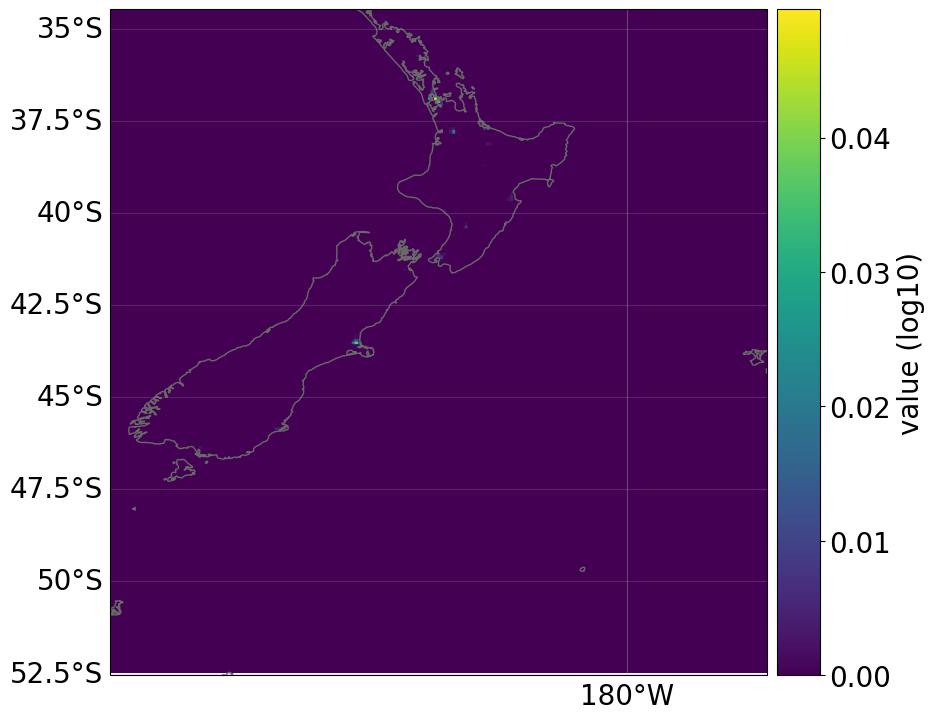

In [4]:
# not needed for impact calculations
# visualize the define exposure
exp_nz.plot_raster()
print('\n Raster properties exposures:', exp_nz.meta)

## Hazard

### Cyclones

In [5]:
from climada.hazard import TCTracks, TropCyclone, Centroids
from climada.entity import ImpfTropCyclone

# Load histrocial tropical cyclone tracks from ibtracs over the North Atlantic basin between 2010-2012
ibtracks_nz = TCTracks.from_ibtracs_netcdf(provider='wellington', basin='SP', year_range=(2010, 2023), correct_pres=True)
print('num tracks hist:', ibtracks_nz.size)

2024-07-17 12:10:23,728 - climada.hazard.tc_tracks - WARNING - `correct_pres` is deprecated. Use `estimate_missing` instead.
2024-07-17 12:10:24,047 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ming/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-07-17 12:10:24,872 - climada.hazard.tc_tracks - WARNING - 94 storm events are discarded because no valid wind/pressure values have been found: 2010020S14147, 2010022S12160, 2010027S14184, 2010038S08194, 2010051S06195, ...


/home/ming/mambaforge/envs/climada_stable/lib/python3.9/site-packages/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


num tracks hist: 47


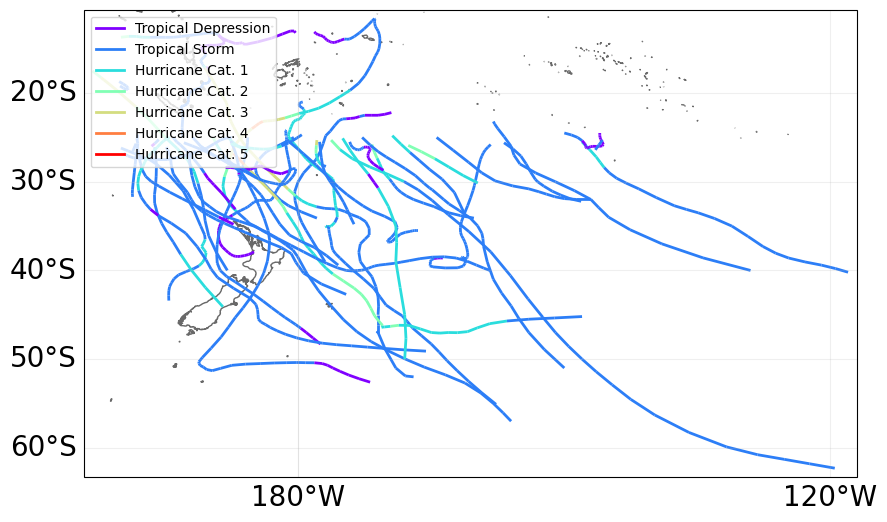

In [6]:
# not needed for calculations
# visualize tracks
ax = ibtracks_nz.plot()
ax.get_legend()._loc = 2

In [7]:
# Define the centroids from the exposures position
lat = exp_nz.gdf['latitude'].values
lon = exp_nz.gdf['longitude'].values
centrs = Centroids.from_lat_lon(lat, lon)
centrs.check()

In [8]:
# Using the tracks, compute the windspeed at the location of the centroids
haz_tc = TropCyclone.from_tracks(ibtracks_nz, centroids=centrs)
haz_tc.check()

In [9]:
# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

In [10]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [11]:
# Exposures: rename column and assign id
exp_nz.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_nz.gdf['impf_' + haz_type] = haz_id
exp_nz.check()

In [12]:
# Compute impact
imp_tc = ImpactCalc(exp_nz, impf_set, haz_tc).impact()  # Do not save the results geographically resolved (only aggregate values)

In [13]:
exp_nz.gdf

,value,latitude,longitude,geometry,region_id,impf_TC,centr_TC
0,0.000000e+00,-50.875000,165.958333,POINT (165.95833 -50.87500),554,1,0
1,0.000000e+00,-50.875000,166.041667,POINT (166.04167 -50.87500),554,1,1
2,0.000000e+00,-50.875000,166.125000,POINT (166.12500 -50.87500),554,1,2
3,0.000000e+00,-50.541667,166.125000,POINT (166.12500 -50.54167),554,1,3
4,0.000000e+00,-50.541667,166.208333,POINT (166.20833 -50.54167),554,1,4
...,...,...,...,...,...,...,...
4194,4.537091e-06,-36.791667,175.125000,POINT (175.12500 -36.79167),554,1,4194
4195,3.041893e-07,-36.208333,175.375000,POINT (175.37500 -36.20833),554,1,4195
4196,6.579583e-07,-36.208333,175.458333,POINT (175.45833 -36.20833),554,1,4196
4197,6.884373e-07,-36.291667,175.541667,POINT (175.54167 -36.29167),554,1,4197


In [14]:
# aai_agg is the Aggregated average annual impact
print(f"Aggregated over New Zealand, average annual impact: {imp_tc.aai_agg}")

Aggregated over New Zealand, average annual impact: 4.5621755663973166e-07


In [15]:
# expected annual impact, illustrate that this data is 
# spatially resolved data, with same number of elements as gridded data
print(f"eai_exp: {imp_tc.eai_exp}")
print("Number of elements: ", len(imp_tc.eai_exp))
print("Summed value of elements equal to aggregate", sum(imp_tc.eai_exp))

eai_exp: [0. 0. 0. ... 0. 0. 0.]
Number of elements:  4199
Summed value of elements equal to aggregate 4.562175566397315e-07


/home/ming/mambaforge/envs/climada_stable/lib/python3.9/site-packages/climada/util/coordinates.py:2749: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(
/home/ming/mambaforge/envs/climada_stable/lib/python3.9/site-packages/climada/util/coordinates.py:2492: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... 

<GeoAxes: title={'center': 'Expected annual impact'}>

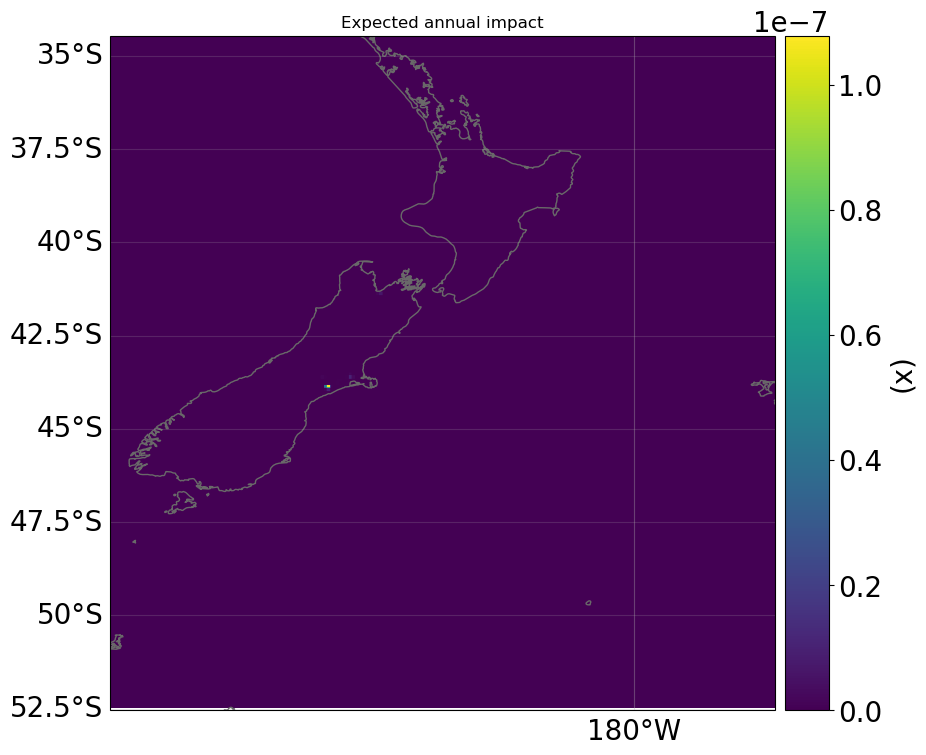

In [16]:
imp_tc.plot_raster_eai_exposure(save_tiff="eai.tif", label="(x)")